# Modeling Networks with Spatial Extent in NEST

Hans Ekkehard Plesser, 2024-01-17, based on [NEST Tutorials Part 4](https://nest-simulator.readthedocs.io/en/stable/tutorials/pynest_tutorial/part_4_spatially_structured_networks.html#pynest-tutorial-4)

For detailed documentation, see [Spatially Structured Networks Documentation](https://nest-simulator.readthedocs.io/en/stable/networks/spatially_structured_networks.html#spatial-networks).

For theory on expected distributions and tests, see  
Daniel Hjertholm  
*Statistical tests for connection algorithms for structured neural networks*  
Master thesis, Norwegian University of Life Sciences, 2013. http://hdl.handle.net/11250/189117

## Defining spatially distributed nodes


In [1]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (3, 3)

In [3]:
import numpy as np
import pandas as pd

In [4]:
import nest
nest.set_verbosity('M_ERROR')


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Oct 15 2023 14:47:07

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



### Nodes on a regular grid

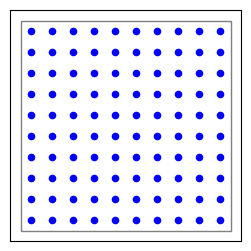

In [6]:
positions = nest.spatial.grid(
    shape=[10, 10],   # the number of rows and column in this grid ...
    extent=[2., 2.])  # the size of the grid in mm
grid_nodes = nest.Create('iaf_psc_alpha', positions=positions)
nest.PlotLayer(grid_nodes);

#### Node collections with spatial information have metadata

In [7]:
grid_nodes

NodeCollection(metadata=spatial, model=iaf_psc_alpha, size=100, first=1, last=100)

In [8]:
grid_nodes.spatial

{'center': (0.0, 0.0),
 'edge_wrap': False,
 'extent': (2.0, 2.0),
 'network_size': 100,
 'shape': (10, 10)}

### Nodes placed freely in space

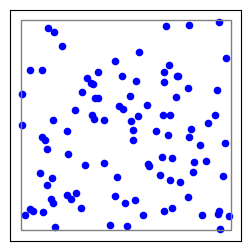

In [12]:
positions = nest.spatial.free(
    nest.random.uniform(min=-0.5, max=0.5),  # using random positions in a uniform distribution
    num_dimensions=2)  # have to specify number of dimensions
free_nodes = nest.Create('iaf_psc_alpha', 100, positions=positions)
nest.PlotLayer(free_nodes);

- Uniform distribution along each axis does not yield uniform distribution in plane

### Jittered positions on a grid

- We need to generate explicit positions outside of NEST, since NEST does not support this yet.
- We thus also need to seed the NumPy RNG in this case
- We make the extent a little larger, since coordinates will be in $[-0.53, 0.53)^2$

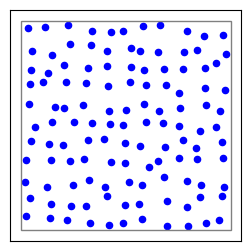

In [13]:
np.random.seed(1234)
x = np.linspace(-0.5, 0.5, num=11)
X, Y = np.meshgrid(x, x)
X += np.random.uniform(-0.03, 0.03, size=X.shape)
Y += np.random.uniform(-0.03, 0.03, size=Y.shape)
pos = nest.spatial.free(list(zip(X.flatten(), Y.flatten())),
                        extent=[1.1, 1.1])
jitt_nodes = nest.Create('iaf_psc_alpha', positions=pos)
nest.PlotLayer(jitt_nodes);

### And in 3D

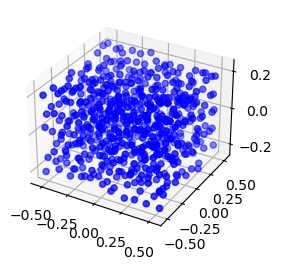

In [14]:
x = np.linspace(-0.5, 0.5, num=11)
z = np.linspace(-0.2, 0.2, num=5)
X, Y, Z = np.meshgrid(x, x, z)
X += np.random.uniform(-0.03, 0.03, size=X.shape)
Y += np.random.uniform(-0.03, 0.03, size=Y.shape)
Z += np.random.uniform(-0.03, 0.03, size=Z.shape)
pos3 = nest.spatial.free(list(zip(X.flatten(), Y.flatten(), Z.flatten())),
                        extent=[1.1, 1.1, 0.5])
jitt3_nodes = nest.Create('iaf_psc_alpha', positions=pos3)
nest.PlotLayer(jitt3_nodes);

## Creating Connections with Spatial Profiles

### Circular mask, distance-dependent connection probability with Gaussian distribution

In [15]:
grid = nest.spatial.grid(
    shape=[30, 30],   # the number of rows and column in this grid ...
    extent=[2., 2.])  # the size of the grid in mm
nodes = nest.Create('iaf_psc_alpha', positions=grid)

conn1 = {'rule': 'pairwise_bernoulli',
         'p': nest.spatial_distributions.gaussian(nest.spatial.distance, 
                                                  std=0.2),
         'mask': {'circular': {'radius': 0.75}},
         'allow_autapses': False
         }

nest.Connect(nodes, nodes, conn_spec=conn1)

#### Targets of center node

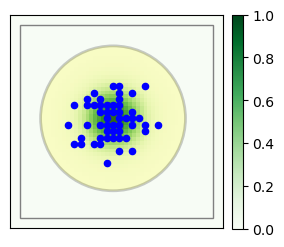

In [16]:
nest.PlotTargets(src_nrn=nest.FindCenterElement(nodes),
                 tgt_layer=nodes,
                 mask=conn1['mask'],
                 probability_parameter=conn1['p']);

#### Targets of node in top-right corner

- Note: must give coordinates to look up as doubles

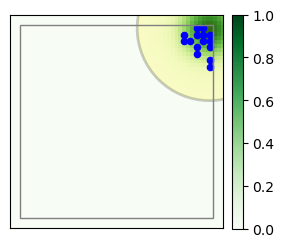

In [17]:
nest.PlotTargets(src_nrn=nest.FindNearestElement(nodes, (1., 1.)),
                 tgt_layer=nodes,
                 mask=conn1['mask'],
                 probability_parameter=conn1['p']);

#### The same with periodic boundary conditions

- Controlled by `edge_wrap` parameter

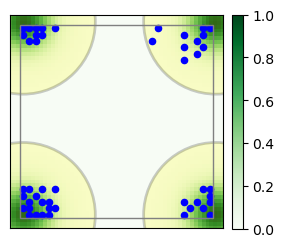

In [18]:
pgrid = nest.spatial.grid(
     shape=[30, 30], 
     extent=[2., 2.],
     edge_wrap=True)
pnodes = nest.Create('iaf_psc_alpha', positions=pgrid)

nest.Connect(pnodes, pnodes, conn_spec=conn1)

nest.PlotTargets(src_nrn=nest.FindNearestElement(pnodes, (1., 1.)),
                 tgt_layer=pnodes,
                 mask=conn1['mask'],
                 probability_parameter=conn1['p']);

### Rectangular mask with non-centered anchor, constant connection probability

- Reset kernel and create new nodes so plotting is not disturbed by connections from previous example

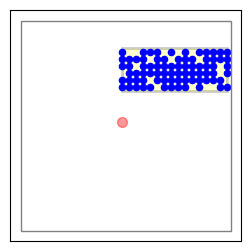

In [28]:
nest.ResetKernel()
nodes = nest.Create('iaf_psc_alpha', positions=grid)

conn2 = {'rule': 'pairwise_bernoulli',
         'p': 0.75,
         'mask': {'rectangular': {'lower_left': [-0.5, -0.2], 
                                  'upper_right': [0.5, 0.2]},
                  'anchor': [0.5, 0.5]
                 },
         'allow_autapses': False
         }
nest.Connect(nodes, nodes, conn2)
nest.PlotTargets(src_nrn=nest.FindCenterElement(nodes),
                 tgt_layer=nodes,
                 mask=conn2['mask']);

### Donut mask, linear distance-dependent connection probability

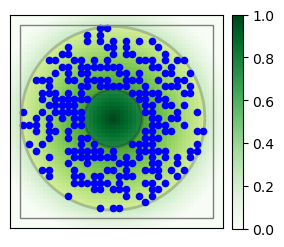

In [29]:
nest.ResetKernel()
nodes = nest.Create('iaf_psc_alpha', positions=grid)

conn3 = {'rule': 'pairwise_bernoulli',
         'p': 1.0 - 0.8 * nest.spatial.distance,
         'mask': {'doughnut': {'inner_radius': 0.3, 'outer_radius': 0.95}},
         }

nest.Connect(nodes, nodes, conn3)
nest.PlotTargets(src_nrn=nest.FindCenterElement(nodes),
                 tgt_layer=nodes,
                 mask=conn3['mask'],
                 probability_parameter=conn3['p']);

### Rectangular mask, fixed outdegree, distance-dependent weights from a gaussian distribution, distance-dependent delays

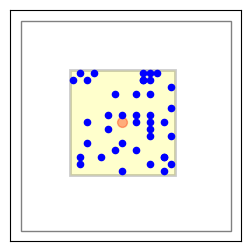

In [33]:
nest.ResetKernel()
nodes = nest.Create('iaf_psc_alpha', positions=grid)

conn4 = {'rule': 'fixed_outdegree',
         'outdegree': 40,
         'mask': {'rectangular': {'lower_left': [-0.5, -0.5], 
                                  'upper_right': [0.5, 0.5]}},
         'allow_autapses': False
         }
syn4 = {'weight': nest.spatial_distributions.gaussian(
             nest.spatial.distance, std=0.25),
        'delay': 0.1 + 2 * nest.spatial.distance}

nest.Connect(nodes, nodes, conn4, syn4)
nest.PlotTargets(src_nrn=nest.FindCenterElement(nodes),
                 tgt_layer=nodes,
                 mask=conn4['mask']);

#### Explore generated network parameters

- Write connection data to file
- Read back into dataframe
- Compute Euclidean distance

In [34]:
nest.DumpLayerConnections(nodes, nodes, 'static_synapse', 'conns.dat')
conns = pd.read_csv('conns.dat', sep=' ', names=['Src', 'Tgt', 'Weight', 'Delay', 'dx', 'dy'])
conns['d'] = np.sqrt(conns.dx**2 + conns.dy**2)

- Get overview over data

In [18]:
conns.loc[:, 'Weight':].describe()

,Weight,Delay,dx,dy,d
count,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000
mean,0.389413,0.826986,-0.001109,0.001594,0.364663
std,0.263646,0.279431,0.276411,0.276819,0.141607
min,0.030671,0.200000,-0.466667,-0.466667,0.066667
25%,0.169013,0.600000,-0.200000,-0.200000,0.266667
50%,0.320531,0.900000,0.000000,0.000000,0.377124
75%,0.566154,1.000000,0.200000,0.200000,0.471405
max,0.965069,1.400000,0.466667,0.466667,0.659967


##### Plot distribution of values

- Note: Depend on how many connections we have at given distances

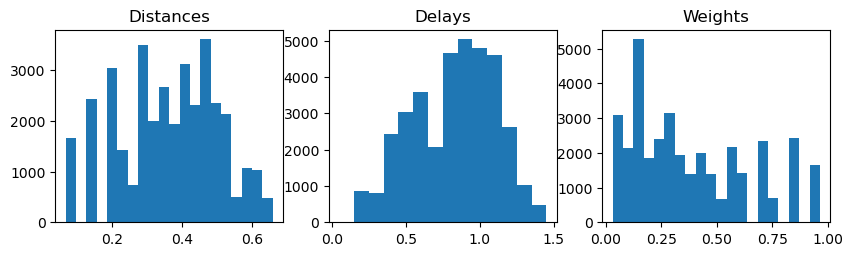

In [35]:
plt.figure(figsize=(10, 2.5))
plt.subplot(1, 3, 1)
plt.hist(conns.d, bins=20);
plt.title('Distances')
plt.subplot(1, 3, 2)
plt.hist(conns.Delay, bins=np.arange(0.05, 1.46, 0.1));
plt.title('Delays')
plt.subplot(1, 3, 3)
plt.hist(conns.Weight, bins=20);
plt.title('Weights');

##### Plot delays and weights relative to distance

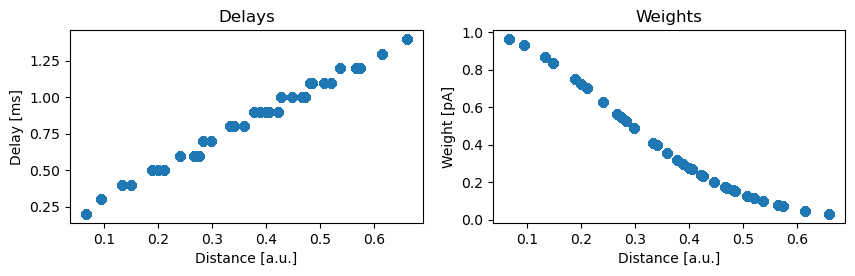

In [36]:
plt.figure(figsize=(10, 2.5))
plt.subplot(1, 2, 1)
plt.scatter(conns.d, conns.Delay);
plt.title('Delays')
plt.xlabel('Distance [a.u.]')
plt.ylabel('Delay [ms]')
plt.subplot(1, 2, 2)
plt.scatter(conns.d, conns.Weight)
plt.title('Weights')
plt.xlabel('Distance [a.u.]')
plt.ylabel('Weight [pA]');